## Differential treatment of housing code violations in different boroughs with high population

* The following analysis is part of the updated pitch memo (1) for the algorithms class taught by Dhrumil Mehta.
* It aims to find out if the treatment of housing code violations in highly populated zipcodes changes from borough to borough.
* The data is from NYC Open Data portal and the US census.

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [3]:
import pyarrow as pa
import pyarrow.parquet as pq

In [129]:
#Loading data with required columns

df = pd.read_csv('Housing_Maintenance_Code_Violations (11).csv', usecols=['Borough', 'Postcode','ViolationStatus'])
df.to_parquet("housing_raw.parquet", index=True)
df

,Borough,Postcode,ViolationStatus
0,BROOKLYN,11209.0,Open
1,QUEENS,11355.0,Close
2,BRONX,10453.0,Close
3,BRONX,10472.0,Close
4,MANHATTAN,10011.0,Open
...,...,...,...
1764564,QUEENS,11104.0,Open
1764565,QUEENS,11104.0,Open
1764566,QUEENS,11104.0,Open
1764567,QUEENS,11104.0,Open


In [130]:
df['Postcode'] = df['Postcode'].apply(lambda x: (str(x).replace(' ', '')))
df['Postcode']

0          11209.0
1          11355.0
2          10453.0
3          10472.0
4          10011.0
            ...   
1764564    11104.0
1764565    11104.0
1764566    11104.0
1764567    11104.0
1764568    11355.0
Name: Postcode, Length: 1764569, dtype: object

In [131]:
df.Postcode = df.Postcode.astype(float)
df.Postcode

0          11209.0
1          11355.0
2          10453.0
3          10472.0
4          10011.0
            ...   
1764564    11104.0
1764565    11104.0
1764566    11104.0
1764567    11104.0
1764568    11355.0
Name: Postcode, Length: 1764569, dtype: float64

In [132]:
df.columns = df.columns.str.replace("Postcode", "zip")

In [133]:
df

,Borough,zip,ViolationStatus
0,BROOKLYN,11209.0,Open
1,QUEENS,11355.0,Close
2,BRONX,10453.0,Close
3,BRONX,10472.0,Close
4,MANHATTAN,10011.0,Open
...,...,...,...
1764564,QUEENS,11104.0,Open
1764565,QUEENS,11104.0,Open
1764566,QUEENS,11104.0,Open
1764567,QUEENS,11104.0,Open


In [134]:
#Adding population to the data

population = pd.read_csv('population.csv')
population

,zip,state,NAME,B01003_001E,B01003_001M,B01003_001MA,B01003_001EA
0,10924,New York,ZCTA5 10924,13508.0,462.0,NaN,NaN
1,11366,New York,ZCTA5 11366,14360.0,857.0,NaN,NaN
2,11364,New York,ZCTA5 11364,36215.0,1308.0,NaN,NaN
3,13803,New York,ZCTA5 13803,4243.0,329.0,NaN,NaN
4,11374,New York,ZCTA5 11374,43507.0,1626.0,NaN,NaN
...,...,...,...,...,...,...,...
1789,14063,New York,ZCTA5 14063,14302.0,474.0,NaN,NaN
1790,13807,New York,ZCTA5 13807,1163.0,199.0,NaN,NaN
1791,12507,New York,ZCTA5 12507,250.0,64.0,NaN,NaN
1792,12858,New York,ZCTA5 12858,116.0,61.0,NaN,NaN


In [135]:
#Cleaning

population.zip = population.zip.astype(float)
population.zip

0       10924.0
1       11366.0
2       11364.0
3       13803.0
4       11374.0
         ...   
1789    14063.0
1790    13807.0
1791    12507.0
1792    12858.0
1793    14729.0
Name: zip, Length: 1794, dtype: float64

In [140]:
#Exporting csv with zipcode-wise count of open and closed violations

df.groupby(['Borough', 'zip']).ViolationStatus.value_counts().to_csv('borough_zip_vio.csv')

In [142]:
#reading csv with zipcode-wise count of open and closed violations

open_close_status = pd.read_csv('borough_zip_vio.csv')
open_close_status

,Borough,zip,ViolationStatus,ViolationStatus.1
0,BRONX,1901.0,Open,10
1,BRONX,2009.0,Open,3
2,BRONX,2015.0,Open,7
3,BRONX,2015.0,Close,6
4,BRONX,2016.0,Close,9
...,...,...,...,...
396,STATEN ISLAND,10312.0,Open,423
397,STATEN ISLAND,10312.0,Close,205
398,STATEN ISLAND,10314.0,Open,1524
399,STATEN ISLAND,10314.0,Close,686


In [143]:
#Cleaning
open_close_status.columns = open_close_status.columns.str.replace("ViolationStatus.1", "vio_count")

In [144]:
#joining the data with population 
new = open_close_status.join(population.set_index('zip'), on='zip', how='left')
new

,Borough,zip,ViolationStatus,vio_count,state,NAME,B01003_001E,B01003_001M,B01003_001MA,B01003_001EA
0,BRONX,1901.0,Open,10,NaN,NaN,NaN,NaN,NaN,NaN
1,BRONX,2009.0,Open,3,NaN,NaN,NaN,NaN,NaN,NaN
2,BRONX,2015.0,Open,7,NaN,NaN,NaN,NaN,NaN,NaN
3,BRONX,2015.0,Close,6,NaN,NaN,NaN,NaN,NaN,NaN
4,BRONX,2016.0,Close,9,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
396,STATEN ISLAND,10312.0,Open,423,New York,ZCTA5 10312,61392.0,1686.0,NaN,NaN
397,STATEN ISLAND,10312.0,Close,205,New York,ZCTA5 10312,61392.0,1686.0,NaN,NaN
398,STATEN ISLAND,10314.0,Open,1524,New York,ZCTA5 10314,89792.0,1843.0,NaN,NaN
399,STATEN ISLAND,10314.0,Close,686,New York,ZCTA5 10314,89792.0,1843.0,NaN,NaN


In [145]:
#Cleaning

new = new.drop(columns=['state', 'NAME', 'B01003_001M', 'B01003_001MA', 'B01003_001EA'])
new

,Borough,zip,ViolationStatus,vio_count,B01003_001E
0,BRONX,1901.0,Open,10,NaN
1,BRONX,2009.0,Open,3,NaN
2,BRONX,2015.0,Open,7,NaN
3,BRONX,2015.0,Close,6,NaN
4,BRONX,2016.0,Close,9,NaN
...,...,...,...,...,...
396,STATEN ISLAND,10312.0,Open,423,61392.0
397,STATEN ISLAND,10312.0,Close,205,61392.0
398,STATEN ISLAND,10314.0,Open,1524,89792.0
399,STATEN ISLAND,10314.0,Close,686,89792.0


In [146]:
new.columns = new.columns.str.replace('B01003_001E', 'population')

In [147]:
#For sanity sake, filtering out zipcodes where population is not available
#Many zipcodes with funny values like 123 and 1245 or even 1122226 were dropped because of this step

new = new.dropna(subset=['population'])
new.reset_index(drop=True)

,Borough,zip,ViolationStatus,vio_count,population
0,BRONX,10451.0,Close,8838,48136.0
1,BRONX,10451.0,Open,6686,48136.0
2,BRONX,10452.0,Close,24338,75452.0
3,BRONX,10452.0,Open,15367,75452.0
4,BRONX,10453.0,Close,19996,81716.0
...,...,...,...,...,...
360,STATEN ISLAND,10310.0,Close,533,23800.0
361,STATEN ISLAND,10312.0,Open,423,61392.0
362,STATEN ISLAND,10312.0,Close,205,61392.0
363,STATEN ISLAND,10314.0,Open,1524,89792.0


In [113]:
#Getting zipcode wise total violations 
new.groupby('zip').vio_count.sum().to_csv('zip_wise_vio.csv')

In [119]:
#reading the csv to make a new df

zip_wise_vio = pd.read_csv('zip_wise_vio.csv')
zip_wise_vio.columns = zip_wise_vio.columns.str.replace('vio_count', 'vio_count_total')
zip_wise_vio

,zip,vio_count_total
0,10001.0,2492
1,10002.0,8872
2,10003.0,7748
3,10004.0,94
4,10005.0,154
5,10006.0,210
6,10007.0,383
7,10009.0,7921
8,10010.0,1935
9,10011.0,6198


In [152]:
#Merging it with the dataframe to get population, total violations, and open and close count per zipcode in the city

new = new.join(zip_wise_vio.set_index('zip'), on='zip', how='right')
new

,Borough,zip,ViolationStatus,vio_count,population,vio_count_total
150,MANHATTAN,10001.0,Open,1263,24117.0,2492
151,MANHATTAN,10001.0,Close,1229,24117.0,2492
152,MANHATTAN,10002.0,Close,4844,74479.0,8872
153,MANHATTAN,10002.0,Open,4028,74479.0,8872
154,MANHATTAN,10003.0,Close,4050,53977.0,7748
...,...,...,...,...,...,...
368,QUEENS,11693.0,Open,696,12944.0,995
369,QUEENS,11693.0,Close,299,12944.0,995
370,QUEENS,11694.0,Open,1620,21202.0,2699
371,QUEENS,11694.0,Close,1079,21202.0,2699


In [153]:
new = new.reset_index(drop=True)

In [154]:
new

,Borough,zip,ViolationStatus,vio_count,population,vio_count_total
0,MANHATTAN,10001.0,Open,1263,24117.0,2492
1,MANHATTAN,10001.0,Close,1229,24117.0,2492
2,MANHATTAN,10002.0,Close,4844,74479.0,8872
3,MANHATTAN,10002.0,Open,4028,74479.0,8872
4,MANHATTAN,10003.0,Close,4050,53977.0,7748
...,...,...,...,...,...,...
360,QUEENS,11693.0,Open,696,12944.0,995
361,QUEENS,11693.0,Close,299,12944.0,995
362,QUEENS,11694.0,Open,1620,21202.0,2699
363,QUEENS,11694.0,Close,1079,21202.0,2699


`geom_smooth()` using formula = 'y ~ x'


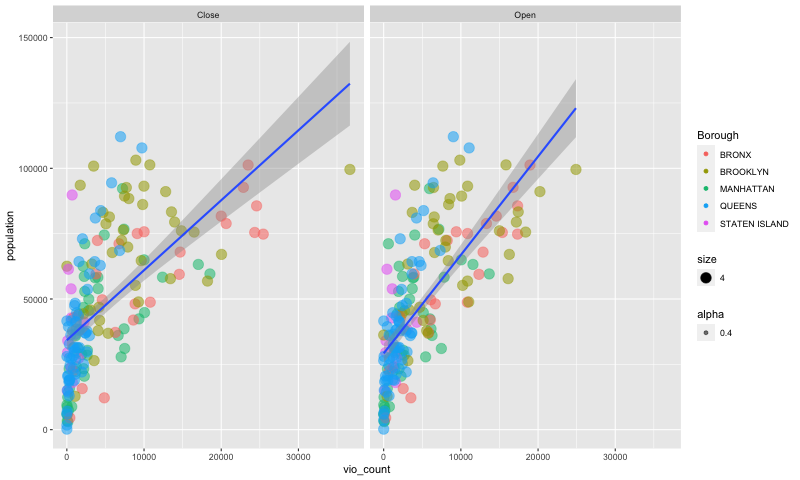

In [171]:
%%R -i new -w 800

#vio_count is spcific to open or close

ggplot(new) + aes(x=vio_count, y=population) +
    geom_point(aes(color=Borough, size=4, alpha=0.4)) + 
    facet_wrap(~ViolationStatus) + geom_smooth(method='lm')

`geom_smooth()` using formula = 'y ~ x'


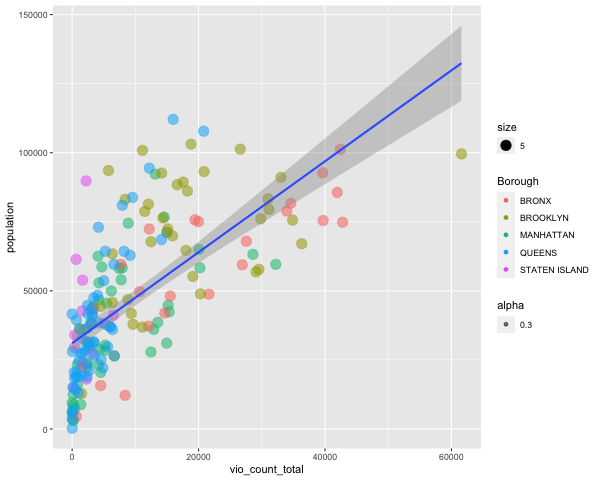

In [200]:
%%R -i new -w 600

open <- new %>% filter(ViolationStatus == "Open")
#I only did this to reduce the duplication of zipcodes as the dataframe has 2 entries of each zipcode
#This filter has no statistical value aside from removing duplicates

ggplot(open) + aes(x=vio_count_total, y=population) +
    geom_point(aes(color=Borough, size=5, alpha=0.3)) + 
     geom_smooth(method='lm')

The goal of this analysis is to show that the treatment of housing maintenance code violations, regardless of it being open or close, is different in Brooklyn and Bronx, compared to other boroughs (based on the scatter plot).

H0 - There is a difference in the way highly populated zipcodes in Brooklyn and Bronx are treated compared to highly populated zipcodes in Manhattan, Queens, or Staten Island boroughs of New York City. The data will be filtered for population above 50,000.

H1 - Among zipcodes with population above 50,000, the treatment of open housing code violations is the same for all boroughs. The data will be filtered for population above 50,000.

In [202]:
%%R -i new

#TEST 1

Bronx_Brooklyn <- new %>% filter(Borough %in% c("BRONX", "BROOKLYN")) %>% filter(population > 50000)
Others <- new %>% filter(Borough %in% c("MANHATTAN", "QUEENS", "STATEN ISLAND")) %>% filter(population > 50000)

t.test(Bronx_Brooklyn$vio_count, Others$vio_count)


	Welch Two Sample t-test

data:  Bronx_Brooklyn$vio_count and Others$vio_count
t = 7.414, df = 139.24, p-value = 1.086e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 4833.428 8348.850
sample estimates:
mean of x mean of y 
11767.553  5176.414 



TEST 1
* Low p-value suggests low probability that this summary is purely due to chance.
* The difference in the means is more than double.

In [188]:
%%R -i new

#TEST 2

Bronx_Queens <- new %>% filter(Borough %in% c("BRONX", "QUEENS")) %>% filter(population > 50000)
Others <- new %>% filter(Borough %in% c("MANHATTAN", "BROOKLYN", "STATEN ISLAND")) %>% filter(population > 50000)

t.test(Bronx_Brooklyn_Queens$vio_count, Others$vio_count)


	Welch Two Sample t-test

data:  Bronx_Brooklyn_Queens$vio_count and Others$vio_count
t = 1.2143, df = 97.424, p-value = 0.2276
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -900.0784 3737.5564
sample estimates:
mean of x mean of y 
 9997.058  8578.319 



TEST 2
* In this combination, the difference in means is not much as the earlier combination.
* The p-value is substantially high.

In [193]:
%%R -i new

#TEST 3

Brooklyn_Queens <- new %>% filter(Borough %in% c("BROOKLYN", "QUEENS")) %>% filter(population > 50000)
Others <- new %>% filter(Borough %in% c("MANHATTAN", "STATEN ISLAND", "BRONX")) %>% filter(population > 50000)

t.test(Bronx_Brooklyn_Queens$vio_count, Others$vio_count)


	Welch Two Sample t-test

data:  Bronx_Brooklyn_Queens$vio_count and Others$vio_count
t = -0.45797, df = 117.13, p-value = 0.6478
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2769.158  1728.970
sample estimates:
mean of x mean of y 
 8868.728  9388.823 



TEST 3
* The difference between the means reduces even further than TEST 2.
* The p-value is higher too, making this highly non-reliable.

### FURTHER QUESTIONS

1) Why is it that the difference is so prominent when Bronx and Brooklyn are put together?
2) When poverty and race are added as variables, does the outcome chance?